# 全书回顾

## 理解大语言模型

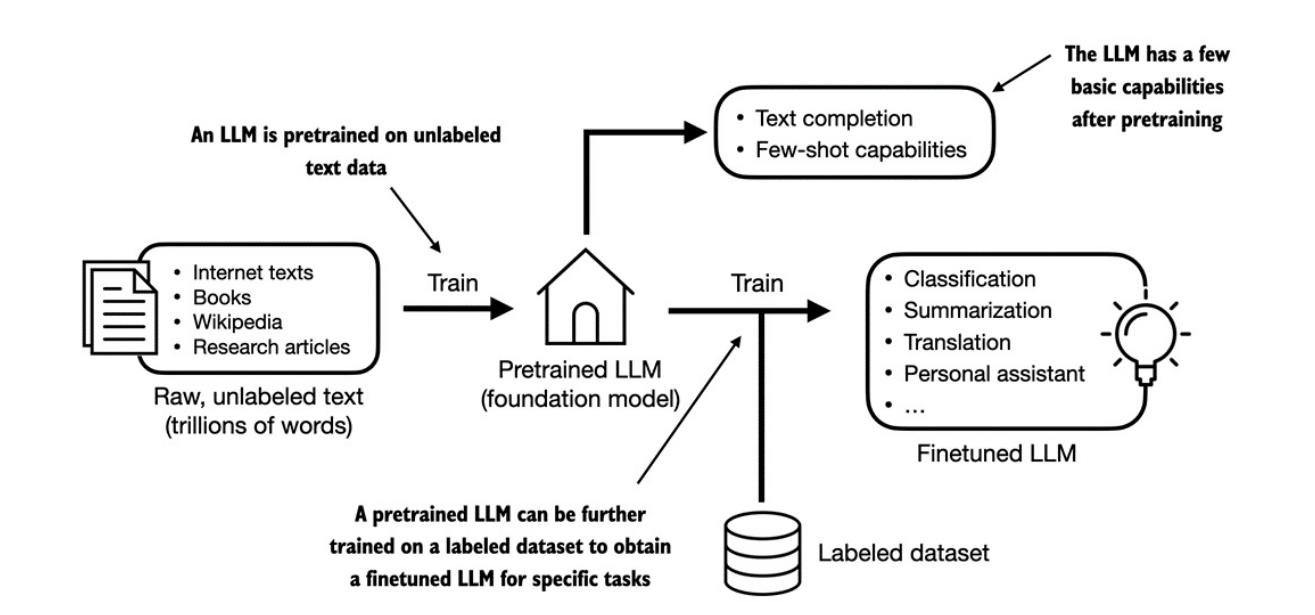

- 大型语言模型（LLMs）已经彻底改变了自然语言处理（NLP）领域。
- 这些模型通常基于Transformer架构，通过在大规模未标注文本上进行预训练，学习语言的统计规律。
- 随后，这些模型可以在特定任务的有标注数据集上进行微调，以执行如文本分类、摘要生成、翻译等任务。

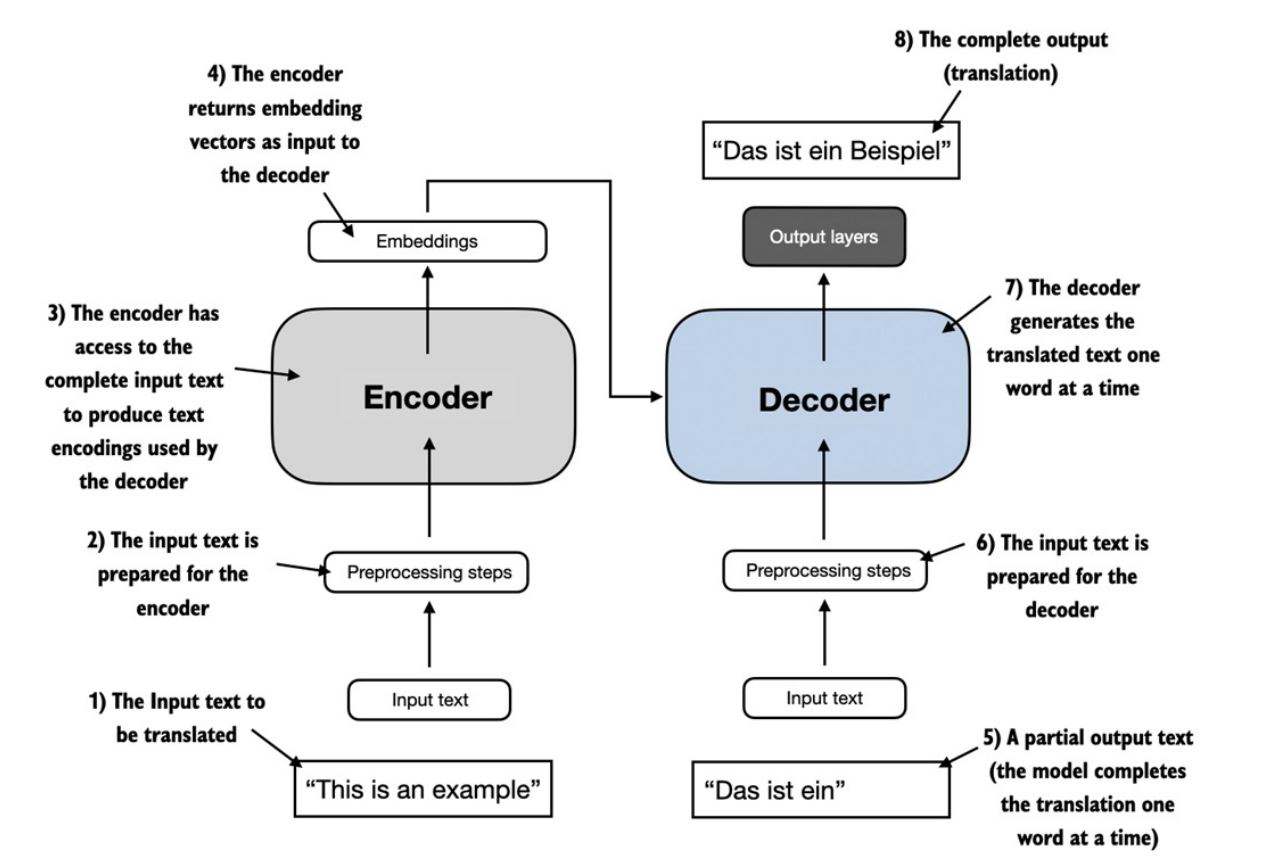

Transformer架构由两个子模块组成：编码器（encoder）和解码器（decoder）。编码器模块处理输入文本，并将其编码为一系列数值表示或向量，这些向量捕捉了输入文本的上下文信息。然后，解码器模块接收这些编码后的向量，并从中生成输出文本。

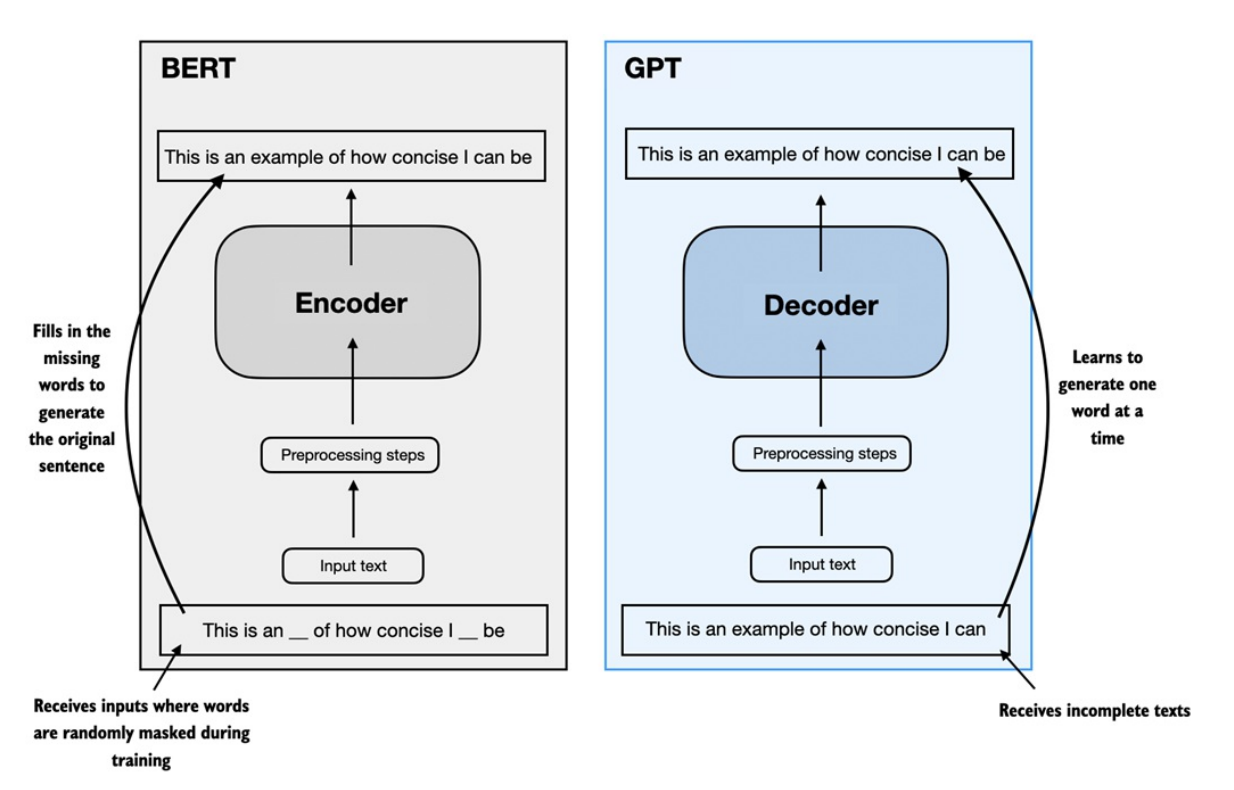

### 构建大语言模型

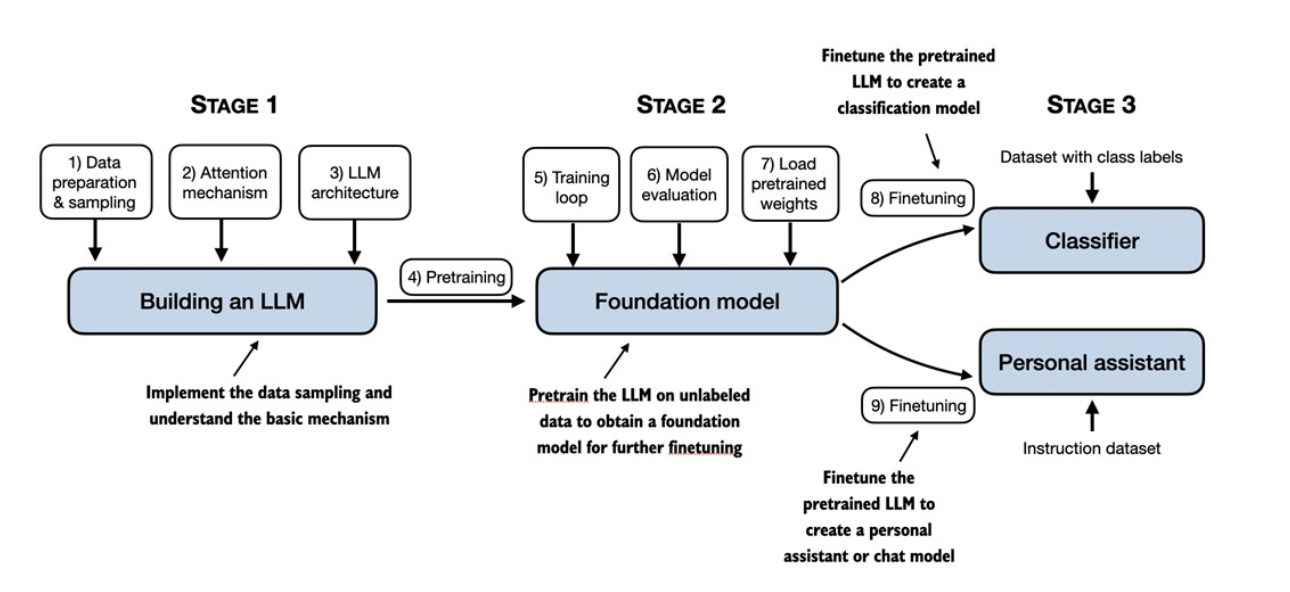

- 第一阶段，对基本的数据进行预处理，并编写作为每个大型语言模型（LLM）核心的注意力机制代码。
- 第二阶段，编写代码并预训练一个能够生成新文本的GPT类大型语言模型。
- 第三阶段，采用一个预训练的大型语言模型，并对其进行微调，以遵循指令，如回答查询或文本分类。

## 数据预处理

我们试图让计算以人类的认知来理解并改造这个世界，那么我们就需要通过一个媒介来表达我们对世界的理解，这个媒介就是tensor。

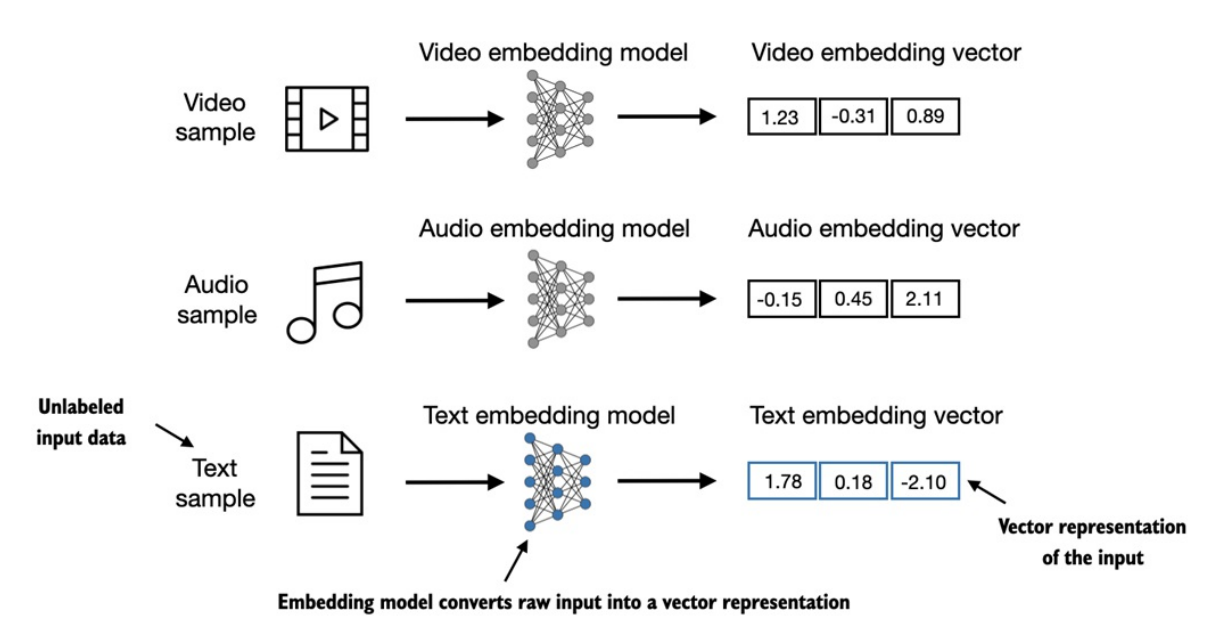

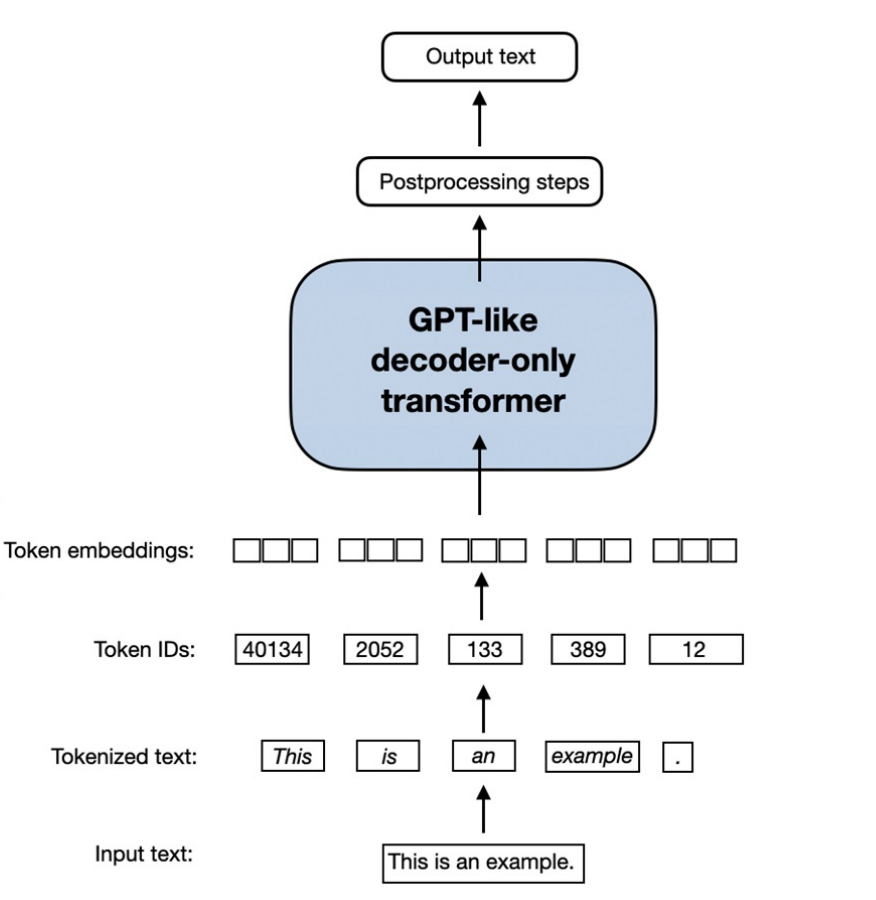

- 原始文本被分解成标记（token），这些标记可以是单词或字符。
- 标记被转换为整数表示，称为标记ID（token ID）。
- 添加特殊标记，如<|unk|>（代表未知词）和<|endoftext|>（代表文本结束），以增强模型的理解能力并处理各种上下文。
- 生成嵌入层。

In [1]:
# 简单的文本分词器：定义了一个名为 SimpleTokenizerV2 的类
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int 
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text
    
# 生成嵌入
max_length = 4 #token 序列长度
output_dim = 256 #embedding维度
vocab_size = 50257 #词表大小

#创建embedding layer
pos_embedding_layer = torch.nn.Embedding(max_length , output_dim)

## 编码注意力机制

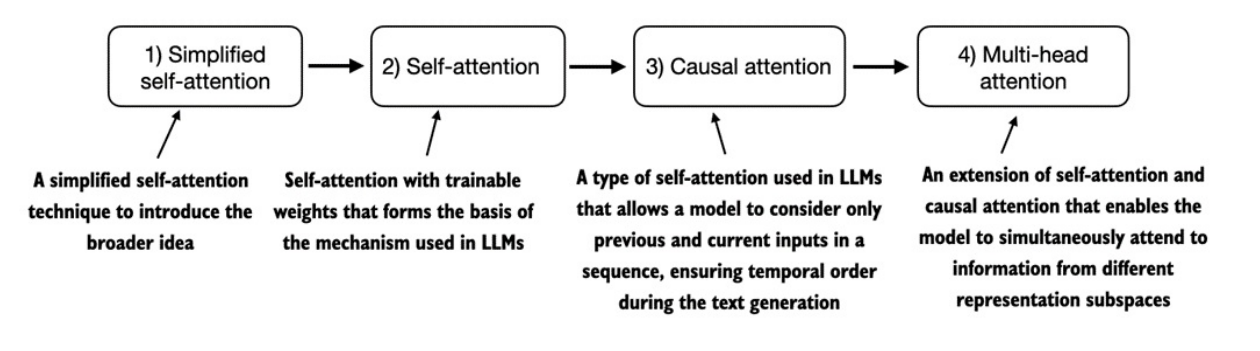

- 首先是从自注意力机制的简化版本开始
- 然后再添加可训练权重
- 因果注意力机制在自注意力机制上添加了一个掩码，使得大型语言模型（LLM）能够一次生成一个单词。
- 最后，多头注意力将注意力机制组织成多个头，从而使模型能够并行捕获输入数据的各个方面。

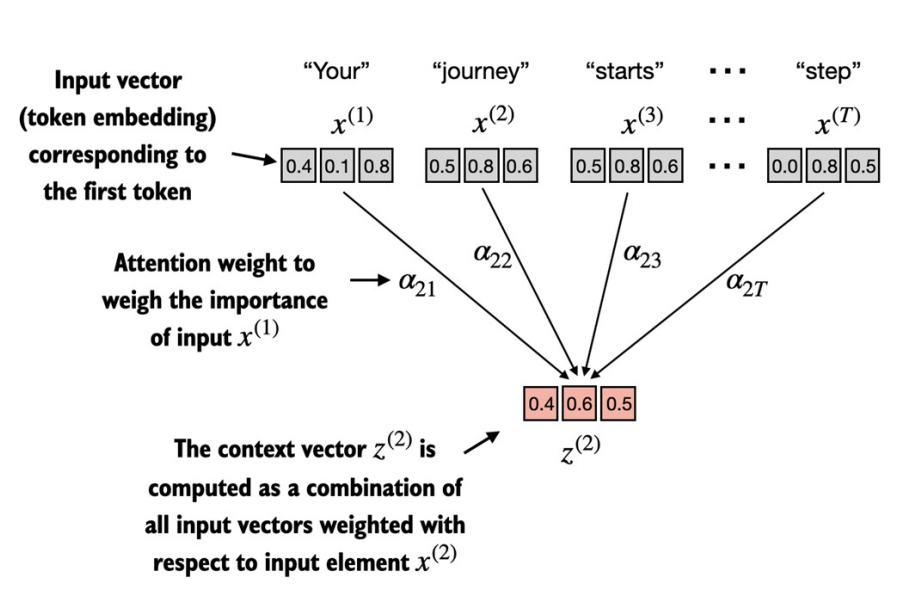

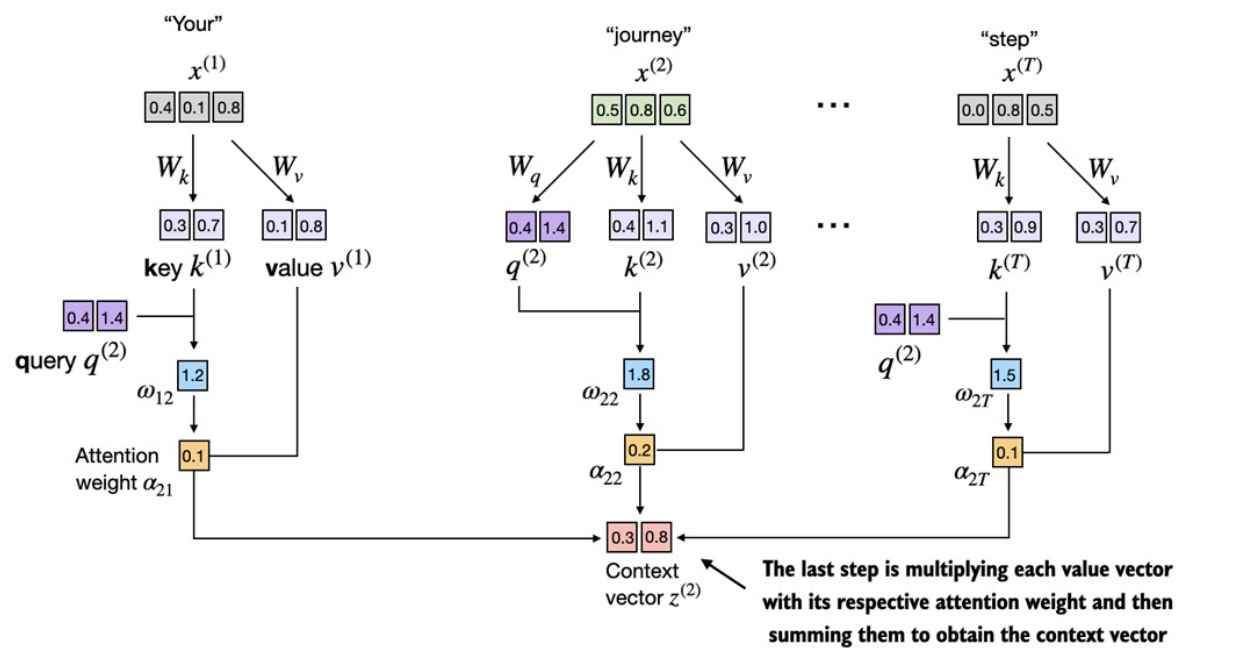

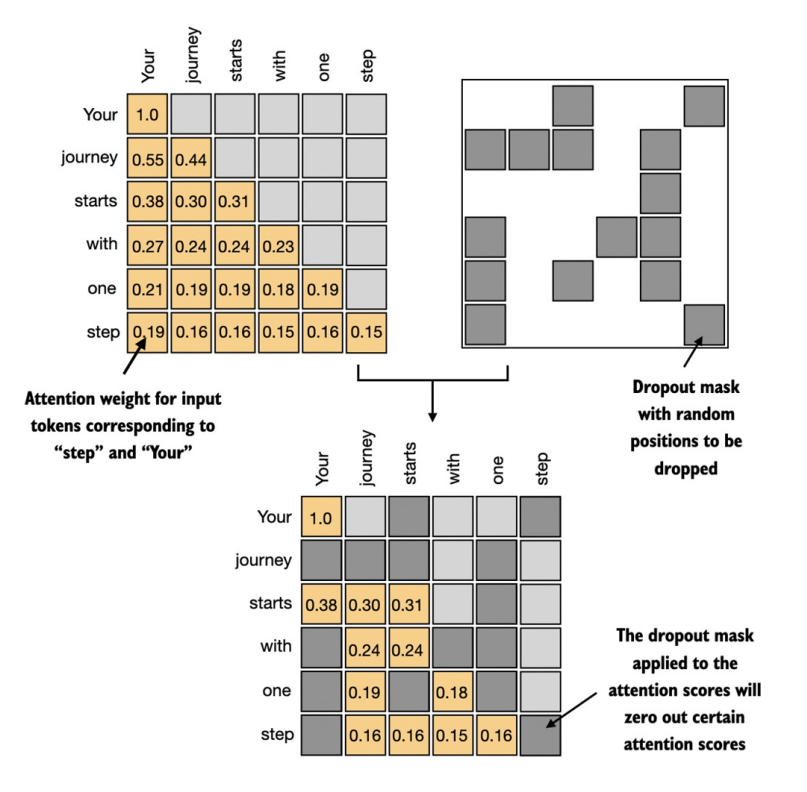

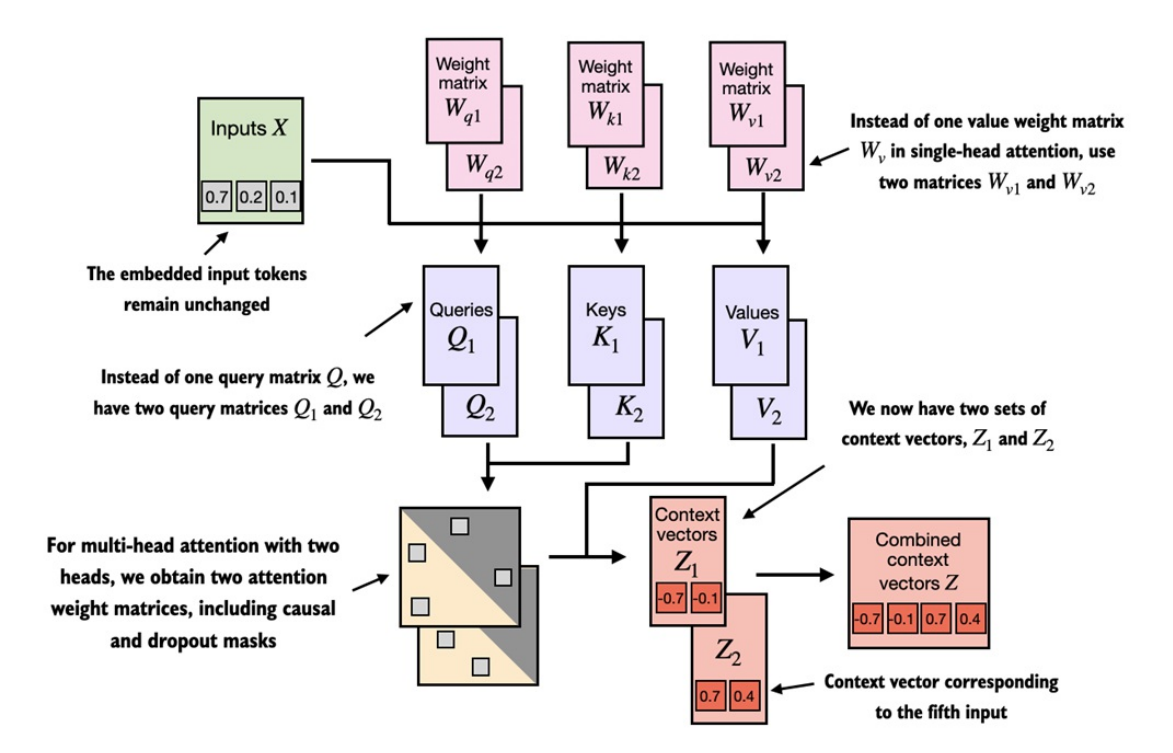

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

## 从零开始实现一个用于文本生成的GPT模型

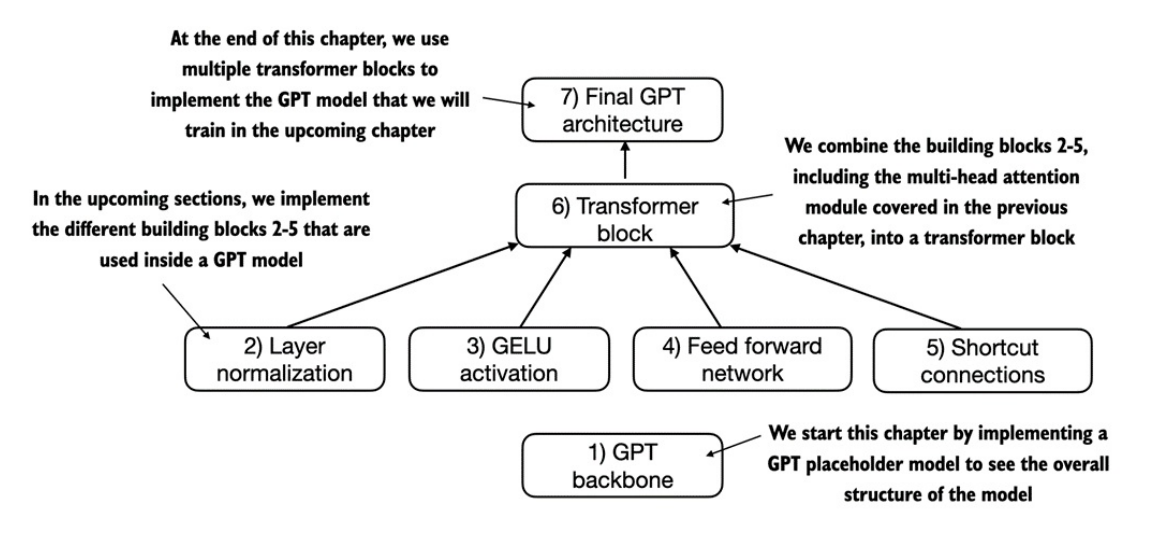

- GPT框架：初步了解并看到模型的整体骨干结构，用于为后续步骤提供一个基础框架。
- 层归一化：有助于稳定模型的训练过程，并加速收敛。
- GELU激活函数：使模型更好地拟合非线性关系。
- 前馈神经网络：接收来自上一层的输入，并输出到下一层。
- 快捷连接：有助于缓解深层网络中的梯度消失问题。

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])#创建分词嵌入层
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])#创建位置嵌入层
        self.drop_emb = nn.Dropout(cfg["drop_rate"])#创建dropout层
        
        self.trf_blocks = nn.Sequential(# 创建一系列Transformer块
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])# 创建最终层归一化层
        self.out_head = nn.Linear(# 创建输出层

            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):# 前向传播方法
        batch_size, seq_len = in_idx.shape# 获取输入的批量大小和序列长度
        tok_embeds = self.tok_emb(in_idx)# 获取分词嵌入
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))# 获取位置嵌入
        x = tok_embeds + pos_embeds  # 将分词嵌入和位置嵌入相加 # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

## 在无标签数据上进行预训练

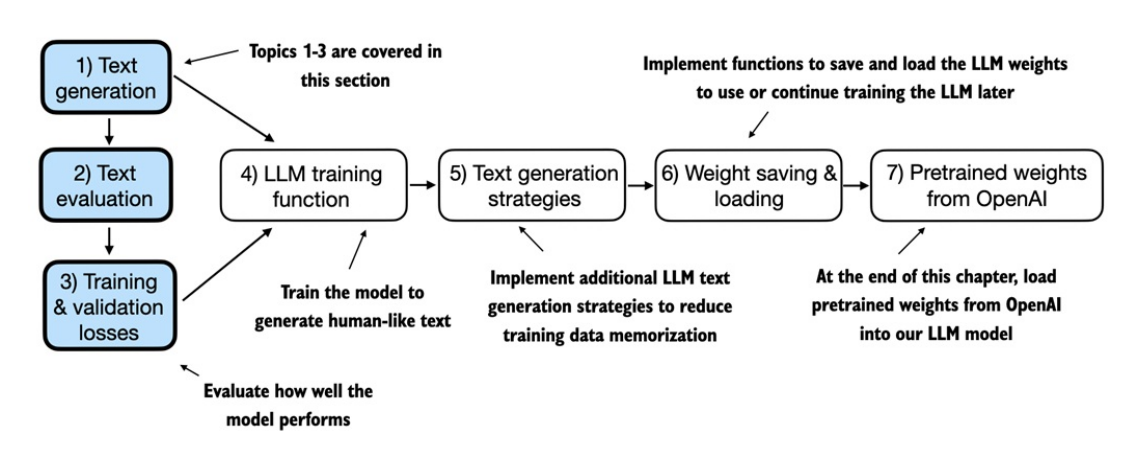

- 计算训练和验证集的损失，以评估在训练期间生成的LLM文本的质量
- 实现一个训练函数并预训练LLM
- 文本生成策略：temperature & top_k
- 保存和加载模型权重以继续训练LLM
- 从OpenAI加载预训练的权重

In [ ]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")
model_configs = {  # 定义模型配置字典
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-small (124M)"  # 选择模型名称
NEW_CONFIG = GPT_CONFIG_124M.copy()  # 复制原始配置
NEW_CONFIG.update(model_configs[model_name])  # 更新配置为选定模型的配置
NEW_CONFIG.update({"context_length": 1024})  # 更新上下文长度为1024
NEW_CONFIG.update({"qkv_bias": True})  # 启用偏置向量
gpt = GPTModel(NEW_CONFIG)  # 使用更新的配置初始化GPT模型
gpt.eval()  # 设置模型为评估模式

gpt = GPTModel(NEW_CONFIG)  # 使用更新的配置初始化GPT模型
gpt.eval()  # 设置模型为评估模式
def assign(left, right):  # 定义assign函数
    if left.shape != right.shape:  # 如果形状不匹配
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")  # 抛出错误
    return torch.nn.Parameter(torch.tensor(right))  # 返回右张量作为可训练参数
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);
torch.manual_seed(123)  # 设置随机种子
token_ids = generate(  # 生成新文本
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))  # 打印输出文本